<a href="https://colab.research.google.com/github/haneulllll/Deeplearning/blob/practice/lab5_Sequence_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN 모델 생성하기

**애플(AAPL) 데이터의 RNN 모델 생성하기**

# **첫번째 RNN 모델**

**import package**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

**GPU/CPU setting**


1. 상단메뉴의 런타임 - 런타임 유형 변경 - 하드웨어 가속기 메뉴에서 GPU를 선택 - 저장

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda' :
  torch.cuda.manual_seed_all(777)

cuda


**데이터 불러오기**

In [ ]:
import yfinance as yf

aapl = yf.download('AAPL', start = '2019-01-01', end = '2023-12-31')
aapl

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793781,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029240,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481926,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402950,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077839,164101200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


**데이터 시각화**

<Axes: xlabel='Date'>

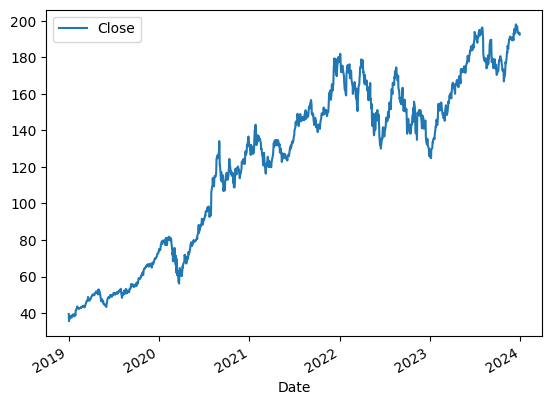

In [ ]:
import pandas as pd

df_aapl = pd.DataFrame(aapl['Close'])
df_aapl.plot()

**데이터 전처리**

train용 : 2019 ~ 2022년도 데이터  
test용 : 2023 ~ 2024년도 데이터

예측을 위해 학습할 data 수 : 15

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data_aapl = df_aapl.values
scaler = MinMaxScaler(feature_range=(0,1))
data_aapl = scaler.fit_transform(data_aapl)

train_ratio = 0.8
split = int(train_ratio*len(data_aapl))
aapl_train = data_aapl[:split, :]
aapl_test = data_aapl[split:, :]

print(aapl_train.shape)
print(aapl_test.shape)

(1006, 1)
(252, 1)


In [ ]:
sequence_length = 15

x_train, y_train = [], []
for i in range(sequence_length, len(aapl_train)) :
  x_train.append(aapl_train[i-sequence_length:i,0])
  y_train.append(aapl_train[i,0])

x_test, y_test = [], []
for i in range(sequence_length, len(aapl_test)) :
  x_test.append(aapl_test[i-sequence_length:i,0])
  y_test.append(aapl_test[i,0])

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train = torch.FloatTensor(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_train = torch.FloatTensor(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test = torch.FloatTensor(x_test)
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_test = torch.FloatTensor(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([991, 15, 1]) torch.Size([991, 1]) torch.Size([237, 15, 1]) torch.Size([237, 1])


**데이터를 배치화하기**

In [ ]:
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

**Model 생성**

-- Hidden layer 수 : 2개

-- 활성화 함수 : Sigmoid


-- Optimization 기법 : Adam

In [ ]:
class RNN(nn.Module) :
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device) :
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.sequence_length = sequence_length
    self.num_layers = num_layers
    self.device = device
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,1), nn.Sigmoid())

  def forward(self, x) :
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.rnn(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)

    return out

In [ ]:
# 파라미터 정의 -> input_size 1로 설정 / Hidden layer 수는 2로 설정 / Hidden layer node 수는 5로 설정
input_size = 1
num_layers = 2
hidden_size = 5

model = RNN(input_size=input_size,hidden_size = hidden_size,sequence_length = sequence_length,num_layers = num_layers, device = device).to(device)
model

RNN(
  (rnn): RNN(1, 5, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=75, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
# 파라미터 정의 -> 반복횟수 200으로 설정 / learning_rate는 0.01로 설정

num_epochs = 200
learning_rate = 0.01

# 손실함수, 최적화기법 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Train 과정**

In [ ]:
loss_list = []
for epoch_num in range(num_epochs) :
  average_cost = 0

  for batch_idx, (x_data, y_label) in enumerate(train_loader) :
    num_of_mini_batch = len(train_loader)
    x_data = x_data.to(device)
    label = y_label.to(device)

    optimizer.zero_grad()
    y_predict = model(x_data)
    loss = criterion(y_predict, label)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 0.16775
Epoch 2 Loss 0.12822
Epoch 3 Loss 0.08860
Epoch 4 Loss 0.05859
Epoch 5 Loss 0.00959
Epoch 6 Loss 0.00760
Epoch 7 Loss 0.00398
Epoch 8 Loss 0.00346
Epoch 9 Loss 0.00322
Epoch 10 Loss 0.00305
Epoch 11 Loss 0.00298
Epoch 12 Loss 0.00289
Epoch 13 Loss 0.00286
Epoch 14 Loss 0.00280
Epoch 15 Loss 0.00277
Epoch 16 Loss 0.00273
Epoch 17 Loss 0.00272
Epoch 18 Loss 0.00270
Epoch 19 Loss 0.00271
Epoch 20 Loss 0.00272
Epoch 21 Loss 0.00276
Epoch 22 Loss 0.00280
Epoch 23 Loss 0.00284
Epoch 24 Loss 0.00290
Epoch 25 Loss 0.00295
Epoch 26 Loss 0.00301
Epoch 27 Loss 0.00306
Epoch 28 Loss 0.00310
Epoch 29 Loss 0.00313
Epoch 30 Loss 0.00316
Epoch 31 Loss 0.00316
Epoch 32 Loss 0.00314
Epoch 33 Loss 0.00307
Epoch 34 Loss 0.00292
Epoch 35 Loss 0.00261
Epoch 36 Loss 0.00209
Epoch 37 Loss 0.00139
Epoch 38 Loss 0.00091
Epoch 39 Loss 0.00113
Epoch 40 Loss 0.00292
Epoch 41 Loss 0.00745
Epoch 42 Loss 0.00342
Epoch 43 Loss 0.00837
Epoch 44 Loss 0.01063
Epoch 45 Loss 0.03147
Epoch 46 Loss 0.006

**Validation 과정**

In [ ]:
with torch.no_grad() :
  num_total_data = 0
  correct = 0
  for batch_idx, (data, labels) in enumerate(test_loader) :

    num_of_mini_batch = len(test_loader)

    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

print("Test Loss {:.5f}".format(average_cost))

Test Loss 0.00253


**예측/실제 데이터 비교**

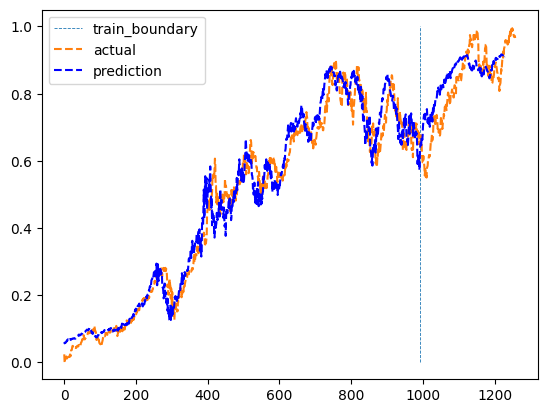

In [ ]:
with torch.no_grad() :
  train_pred= []
  test_pred = []

  for batch_idx, (x_data, y_label) in enumerate(train_loader) :
    x_data = x_data.to(device)
    label = y_label.to(device)
    y_predict = model(x_data)
    train_pred += y_predict.cpu().numpy().tolist()

  for batch_idx, (x_data, y_label) in enumerate(test_loader) :
    x_data = x_data.to(device)
    label = y_label.to(device)
    y_predict = model(x_data)
    test_pred += y_predict.cpu().numpy().tolist()

total = train_pred + test_pred
plt.figure()
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total, 'b--')
plt.legend(['train_boundary', 'actual', 'prediction'])
plt.show()

# **두번째 RNN 모델**

**데이터 전처리**

train용 : 2019 ~ 2022년도 데이터  
test용 : 2023 ~ 2024년도 데이터

예측을 위해 학습할 data 수 : 15

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data_aapl = df_aapl.values
scaler = MinMaxScaler(feature_range=(0,1))
data_aapl = scaler.fit_transform(data_aapl)

train_ratio = 0.8
split = int(train_ratio*len(data_aapl))
aapl_train = data_aapl[:split, :]
aapl_test = data_aapl[split:, :]

print(aapl_train.shape)
print(aapl_test.shape)

(1006, 1)
(252, 1)


In [ ]:
sequence_length = 15

x_train, y_train = [], []
for i in range(sequence_length, len(aapl_train)) :
  x_train.append(aapl_train[i-sequence_length:i,0])
  y_train.append(aapl_train[i,0])

x_test, y_test = [], []
for i in range(sequence_length, len(aapl_test)) :
  x_test.append(aapl_test[i-sequence_length:i,0])
  y_test.append(aapl_test[i,0])

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
x_train = torch.FloatTensor(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_train = torch.FloatTensor(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test = torch.FloatTensor(x_test)
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_test = torch.FloatTensor(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([991, 15, 1]) torch.Size([991, 1]) torch.Size([237, 15, 1]) torch.Size([237, 1])


**데이터를 배치화하기**

In [ ]:
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False)

**Model 생성**

-- Hidden layer 수 : 3개

-- 활성화 함수 : Sigmoid


-- Optimization 기법 : Adam

In [ ]:
class RNN(nn.Module) :
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device) :
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.sequence_length = sequence_length
    self.num_layers = num_layers
    self.device = device
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length,1), nn.Sigmoid())

  def forward(self, x) :
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.rnn(x,h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)

    return out

In [ ]:
# 파라미터 정의 -> input_size 1로 설정 / Hidden layer 수는 2으로 설정 / Hidden layer node 수는 3으로 설정
input_size = 1
num_layers = 2
hidden_size = 3

model = RNN(input_size=input_size,hidden_size = hidden_size,sequence_length = sequence_length,num_layers = num_layers, device = device).to(device)
model

RNN(
  (rnn): RNN(1, 3, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=45, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
# 파라미터 정의 -> 반복횟수 200으로 설정 / learning_rate는 0.01로 설정

num_epochs = 200
learning_rate = 0.01

# 손실함수, 최적화기법 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

**Train 과정**

In [ ]:
loss_list = []
for epoch_num in range(num_epochs) :
  average_cost = 0

  for batch_idx, (x_data, y_label) in enumerate(train_loader) :
    num_of_mini_batch = len(train_loader)
    x_data = x_data.to(device)
    label = y_label.to(device)

    optimizer.zero_grad()
    y_predict = model(x_data)
    loss = criterion(y_predict, label)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 0.09861
Epoch 2 Loss 0.19057
Epoch 3 Loss 0.08312
Epoch 4 Loss 0.07361
Epoch 5 Loss 0.04716
Epoch 6 Loss 0.02246
Epoch 7 Loss 0.00620
Epoch 8 Loss 0.00551
Epoch 9 Loss 0.00437
Epoch 10 Loss 0.00366
Epoch 11 Loss 0.00319
Epoch 12 Loss 0.00325
Epoch 13 Loss 0.00295
Epoch 14 Loss 0.00317
Epoch 15 Loss 0.00299
Epoch 16 Loss 0.00317
Epoch 17 Loss 0.00308
Epoch 18 Loss 0.00317
Epoch 19 Loss 0.00312
Epoch 20 Loss 0.00314
Epoch 21 Loss 0.00310
Epoch 22 Loss 0.00308
Epoch 23 Loss 0.00305
Epoch 24 Loss 0.00301
Epoch 25 Loss 0.00298
Epoch 26 Loss 0.00296
Epoch 27 Loss 0.00294
Epoch 28 Loss 0.00293
Epoch 29 Loss 0.00292
Epoch 30 Loss 0.00290
Epoch 31 Loss 0.00287
Epoch 32 Loss 0.00286
Epoch 33 Loss 0.00287
Epoch 34 Loss 0.00286
Epoch 35 Loss 0.00284
Epoch 36 Loss 0.00282
Epoch 37 Loss 0.00277
Epoch 38 Loss 0.00273
Epoch 39 Loss 0.00267
Epoch 40 Loss 0.00259
Epoch 41 Loss 0.00250
Epoch 42 Loss 0.00236
Epoch 43 Loss 0.00220
Epoch 44 Loss 0.00194
Epoch 45 Loss 0.00169
Epoch 46 Loss 0.001

**Validation 과정**

In [ ]:
with torch.no_grad() :
  num_total_data = 0
  for batch_idx, (data, labels) in enumerate(test_loader) :

    num_of_mini_batch = len(test_loader)

    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

print("Test Loss {:.5f}".format(average_cost))

Test Loss 0.00312


**예측/실제 데이터 비교**

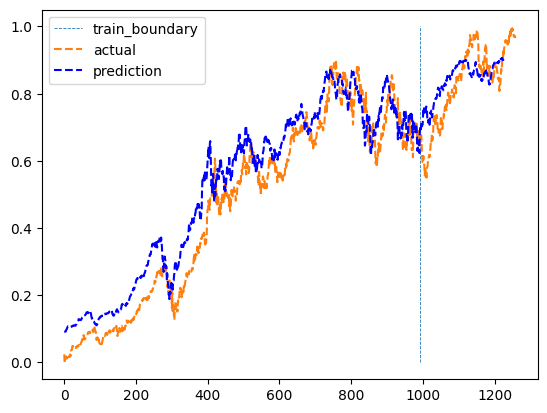

In [ ]:
with torch.no_grad() :
  train_pred= []
  test_pred = []

  for batch_idx, (x_data, y_label) in enumerate(train_loader) :
    x_data = x_data.to(device)
    label = y_label.to(device)
    y_predict = model(x_data)
    train_pred += y_predict.cpu().numpy().tolist()

  for batch_idx, (x_data, y_label) in enumerate(test_loader) :
    x_data = x_data.to(device)
    label = y_label.to(device)
    y_predict = model(x_data)
    test_pred += y_predict.cpu().numpy().tolist()

total = train_pred + test_pred
plt.figure()
plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total, 'b--')
plt.legend(['train_boundary', 'actual', 'prediction'])
plt.show()